# Actor-Critic 算法

## 10.1 简介
- 本书之前的章节讲解了基于值函数的方法（DQN）和基于策略的方法（REINFORCE），其中基于值函数的方法只学习一个价值函数，而基于策略的方法只学习一个策略函数。那么，一个很自然的问题是，有没有什么方法既学习价值函数，又学习策略函数呢？答案就是 Actor-Critic。Actor-Critic 是囊括一系列算法的整体架构，目前很多高效的前沿算法都属于 Actor-Critic 算法，本章接下来将会介绍一种最简单的 Actor-Critic 算法。需要明确的是，Actor-Critic 算法本质上是基于策略的算法，因为这一系列算法的目标都是优化一个带参数的策略，只是会额外学习价值函数，从而帮助策略函数更好地学习。

## 10.2 Actor-Critic
- 回顾一下，在 REINFORCE 算法中，目标函数的梯度中有一项轨迹回报，用于指导策略的更新。REINFOCE 算法用蒙特卡洛方法来估计 $Q(s, a)$，能不能考虑拟合一个值函数来指导策略进行学习呢？这正是 Actor-Critic 算法所做的。在策略梯度中，可以把梯度写成下面这个更加一般的形式：

$$
g = \mathbb{E}[\sum_{t = 0}^{T}\psi_t\nabla_{\theta}\log{\pi_{\theta}(a_t | s_t)}]
$$

- 其中，$\psi_t$ 可以有很多种形式：

$$
\begin{align*}
&1. \sum_{t' = 0}^{T}\gamma^{t'}r_{t'}：轨迹的总回报  \\
&2. \sum_{t' = t}^T\gamma^{t'-t}r_{t'}：动作 a_t 之后的回报  \\
&3. \sum_{t' = t}^T\gamma^{t'-t}r_{t'} - b(s_t)：基准线版本的改进  \\
&4. Q^{\pi_{\theta}}(s_t, a_t)：动作价值函数  \\ 
&5. A^{\pi_{\theta}}(s_t, a_t)：优势函数  \\
&6. r_t + \gamma V^{\pi_{\theta}}(s_{t+1}) - V^{\pi_{\theta}}(s_{t})：时序差分残差
\end{align*}
$$

- 9.5 节提到 REINFORCE 通过蒙特卡洛采样的方法对策略梯度的估计是无偏的，但是方差非常大。我们可以用形式 (3) 引入**基线函数**（baseline function）$b(s_t)$ 来减小方差，此外，我们也可以采用用 Actor-Critic 算法估计一个动作价值函数 $Q$，代替蒙特卡洛采样得到的回报，这便是形式 (4)，这个时候，我们可以把状态价值函数 $V$ 作为基线，从 $Q$ 函数减去这个 $V$ 函数则得到了 $A$ 函数，我们称之为优势函数，这便是形式 (5)，更进一步，我们可以利用 $Q = r + \gamma V$ 等式得到形式 (6)
- 本章将着重介绍形式 (6)， 即通过时序差分残差 $\psi_t = r_t + \gamma V^{\pi_{\theta}}(s_{t+1}) - V^{\pi_{\theta}}(s_{t})$ 来指导策略梯度进行学习，事实上，用 $Q$ 值或者 $V$ 值本质上也是用奖励来进行指导，但是用神经网络进行估计的方法可以减小方差、提高鲁棒性。除此之外，REINFORCE 算法基于蒙特卡洛采样，只能在序列结束后进行更新，这同时也要求任务具有有限的步数，而 Actor-Critic 算法则可以在每一步之后都进行更新，并且不对任务的步数做限制
- 我们将 Actor-Critic 分为两个部分：Actor（策略网络）和 Critic（价值网络），如图 10-1 所示。
    - Actor 要做的是与环境交互，并在 Critic 价值函数的指导下用策略梯度学习一个更好的策略。
    - Critic 要做的是通过 Actor 与环境交互收集的数据学习一个价值函数，这个价值函数会用于判断在当前状态什么动作是好的，什么动作不是好的，进而帮助 Actor 进行策略更新。
    <div align="center">
        <img src="./image/10-1.jpg">
        <center>图10-1 Actor 和 Critic 的关系</center>
    </div> 
- Actor 的更新采用策略梯度的原则，那 Critic 如何更新呢？我们将 Critic 价值网络表示为 $V_{\omega}$，参数为 $\omega$。于是，我们可以采取时序差分残差的学习方式，对于单个数据定义如下价值函数的所示函数：

$$
\mathcal{L}(\omega) = \frac{1}{2}(r + \gamma V_{\omega}(s_{t + 1}) - V_{\omega}(s_{t}))^2
$$

- 与 DQN 中一样，我们采取类似于目标网络的方法，将上式中 $r + \gamma V_{\omega}(s_{t + 1})$ 作为时序差分目标，不会产生梯度来更新价值函数，因此，价值函数的梯度为：

$$
\nabla_{\omega} \mathcal{L}(\omega) = -(r + \gamma V_{\omega}(s_{t + 1}) - V_{\omega}(s_{t})) \nabla_{\omega}V_{\omega}(s_{t})
$$

- 然后使用梯度下降方法来更新 Critic 价值网络参数即可
- Actor-Critic 算法的具体流程如下：
    - 初始化策略网络参数 $\theta$，价值网络参数 $\omega$
    - **for** 序列 $e = 1 \rightarrow E$ **do**
        - &emsp;用当前策略 $\pi_{\theta}$ 采样轨迹 $\{s_1, a_1, r_1, s_2, a_2, r_2, ... \}$ 
        - &emsp;为每一步数据计算: $\delta_t = r_t + \gamma V_{\omega}(s_{t + 1}) - V_{\omega}(s_{t})$
        - &emsp;更新价值参数 $\omega = \omega + \alpha_{\omega} \sum_t \delta_t \nabla_{\omega}V_{\omega}(s_t)$ 
        - &emsp;更新策略参数 $\theta = \theta + \alpha_{\theta} \sum_t \delta_t \nabla_{\theta} \log \pi_{\theta}(a_t | s_t)$
    - **end for**
- 以上就是 Actor-Critic 算法的流程，接下来让我们来用代码实现它，看看效果如何！

## 10.3 Actor-Critic 代码实践
- 我们仍然在车杆环境上进行 Actor-Critic 算法的实验

In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils

- 首先定义策略网络 `PolicyNet`（与 REINFORCE 算法一样）。

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)

- Actor-Critic 算法额外引入一个价值网络，接下来的代码定义价值网络`ValueNet`，其输入是某个状态，输出则是状态的价值

In [3]:
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)

- 现在定义`ActorCritic`算法，主要包含采取动作`take_action()`和更新网络参数`update()`两个函数

In [4]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 gamma, device):
        # 策略网络
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # 价值网络
        # 策略网络优化器
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)  # 价值网络优化器
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        # 时序差分目标
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)  # 时序差分误差
        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        # 均方误差损失函数
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  # 计算策略网络的梯度
        critic_loss.backward()  # 计算价值网络的梯度
        self.actor_optimizer.step()  # 更新策略网络的参数
        self.critic_optimizer.step()  # 更新价值网络的参数

- 定义好 Actor 和 Critic，我们就可以开始实验了，看看 Actor-Critic 在车杆环境上表现如何吧！

In [5]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v0'
env = gym.make(env_name)
env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                    gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wxl/anaconda3/envs/d2l/lib/python3.10/site-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecate

- 在 CartPole-v0 环境中，满分就是 200 分。和 REINFORCE 相似，接下来我们绘制训练过程中每一条轨迹的回报变化图以及其经过平滑处理的版本

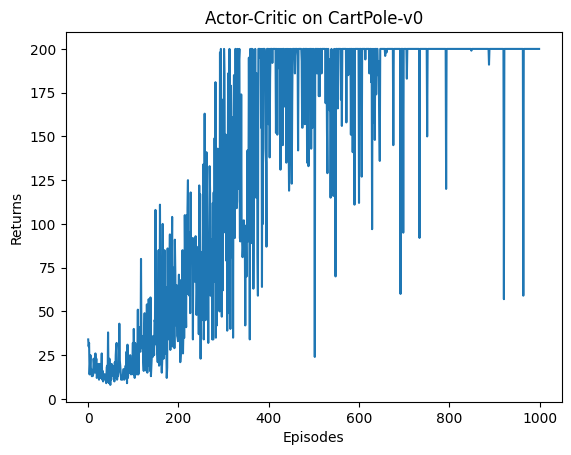

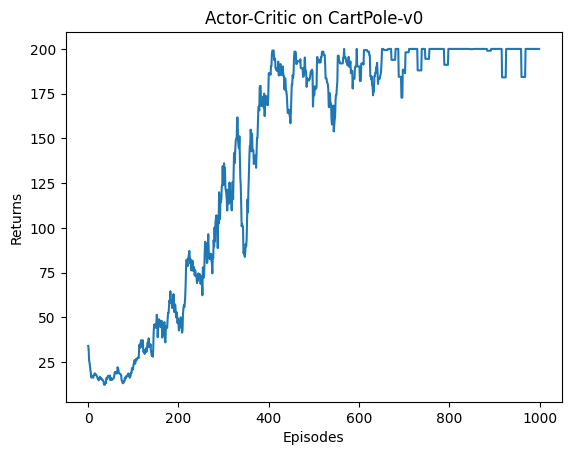

In [6]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Actor-Critic on {}'.format(env_name))
plt.show()

- 根据实验结果我们可以发现，Actor-Critic 算法很快便能收敛到最优策略，并且训练过程非常稳定，抖动情况相比 REINFORCE 算法有了明显的改进，这说明价值函数的引入减小了方差

## 10.4 总结
- 本章讲解了 Actor-Critic 算法，它是基于值函数的方法和基于策略的方法的叠加。价值模块 Critic 在策略模块 Actor 采样的数据中学习分辨什么是好的动作，什么不是好的动作，进而指导 Actor 进行策略更新。随着 Actor 的训练的进行，其与环境交互所产生的数据分布也发生改变，这需要 Critic 尽快适应新的数据分布并给出好的判别。

- Actor-Critic 算法非常实用，后续章节中的 TRPO、PPO、DDPG、SAC 等深度强化学习算法都是在 Actor-Critic 框架下进行发展的。深入了解 Actor-Critic 算法对读懂目前深度强化学习的研究热点大有裨益。

In [9]:
import numpy as np

def kl_divergence(P, Q):
    """
    计算两个离散概率分布P和Q之间的KL散度。
    P和Q是两个概率分布的列表或数组。
    """
    P = np.array(P)
    Q = np.array(Q)
    
    # 确保P和Q是概率分布
    assert np.isclose(np.sum(P), 1) and np.isclose(np.sum(Q), 1)
    
    # 计算KL散度
    kl_div = np.sum(P * np.log(P / Q))
    
    return kl_div

# 定义两个相似的概率分布
P1 = [0.2, 0.5, 0.3]
Q1 = [0.21, 0.49, 0.3]

# 定义两个差异较大的概率分布
P2 = [0.2, 0.5, 0.3]
Q2 = [0.6, 0.1, 0.3]

# 计算KL散度
kl_div1 = kl_divergence(P1, Q1)
kl_div2 = kl_divergence(P2, Q2)

print(f"KL散度 (相似分布): {kl_div1}")
print(f"KL散度 (差异较大分布): {kl_div2}")

KL散度 (相似分布): 0.0003433208248733461
KL散度 (差异较大分布): 0.5849964984834282
